<a href="https://colab.research.google.com/github/Muriloozol/veiculos_automotores/blob/main/veiculos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabalho de Veículos
Para um veículo que deve ser escolhido pela equipe:

1.  Calcular as resistências ao movimento (capítulo 2).
2. Calcular o torque máximo que o layout permite que o carro pode transmitir ao solo (capítulo 3).
3. Para o veículo selecionado (capítulos 5 e 6):
   * Traçar o diagrama de potência líquida no cubo;
   * Determinar acelerações máximas em cada marcha;
   * Determinar aclives máximos em cada marcha;
   * Determinar velocidade máxima e mínima em cada marcha;
   * Determinar o tempo para acelerar da imobilidade até:
      - 80km/h;
      - 100km/h;    
      - velocidade máxima do veículo.
      
      Obs: Para velocidades muito baixas a aceleração é calculada considerando que o veículo consegue transmitir ao solo o torque máximo definido pelo layout.
   * Determinar o tempo para acelerar de 60 km/h para 120 km/h (simulando uma ultrapassagem) usando todas as combinações possíveis de marchas da caixa de transmissão.
4. Calcular a massa dos freios dianteiros e traseiros para freadas de emergência, bem como o tempo e a distância percorrida para imobilizar o veículo a partir das seguintes velocidades (capítulo 4):
    
    1. 80km/h;
    2. 100km/h;
    3. Máxima velocidade do veículo.

5. Comparar os resultados obtidos no item 3 e 4 com os valores que são publicados em revistas especializadas/manual do proprietário.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
massa = 1675 # kg

rendimento_transmissao = 0.9

diametro_pneu = 0.508 # m
raio_estatico = 0.47 * diametro_pneu # [eq. 5.18]
raio_dinamico = 1.02 * raio_estatico # [eq. 5.19]

# Aerodinamica
C_x = 0.26 # Coeficiente de resistencia aerodinamica
A = 2.21 # m2  Area projetada

# curva motor
potencia = [37.0, 111.0, 192.4, 273.8, 355.2, 414.4, 429.2] # kW
rotacao = [1000, 2000, 3000, 4000, 5000, 6000, 7000] # rpm

In [3]:
# Dados do carro retirados do site https://zeperfs.com/fiche4841-nissan-gt-r-nismo.htm#GRDB
v = np.array([63, 112, 161, 206, 257, 321]) # km/h
marchas = [1, 2, 3, 4, 5, 6]
# Conversao de unidade
v = v/3.6 # m/s
w = v/raio_dinamico # rad/s
w = 30 * w/np.pi # rpm

# relacoes de transmissao para cada marcha
relacao_transmissao = 7200/w
relacao_transmissao

array([10.49264085,  5.90211048,  4.10581598,  3.20891443,  2.57212597,
        2.05930334])

### 1. Calcular as resistências ao movimento (capítulo 2)

#### Resistência Mecânica

 <p align=center>$P_c = P_e \eta_m $ </p>

sendo:

$P_c$ - Potência no cubo;

$P_e$ - Potência efetiva no motor;

$\eta_m$ - Rendimento mecânico da transmissão.

Como a potência efetiva do motor é a soma das potências no cubo e a perdida na trans-
missão, pode-se escrever que:
sendo:

<p align=center> $P_m = (1 − \eta_m ) P_e$


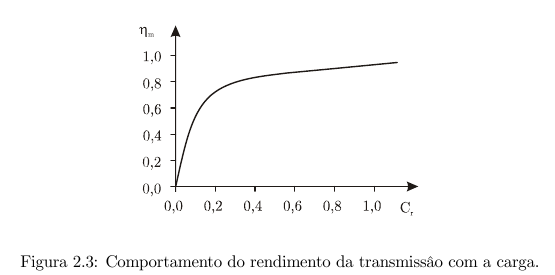

O rendimento mecânico da transmissão de automóveis está, em geral, na faixa de 0,84
a 0,93, variando conforme as soluções construtivas que foram adotadas e com a marcha que
está sendo utilizada. Para alguns tipos de câmbios, onde há uma marcha direta e não ocorre
transmissão de força através das engrenagens da caixa de câmbio, tem-se, nesta marcha, o
maior o rendimento da transmissão.


In [4]:
def resistencia_mecanica(rendimento_transmissao, potencia_motor):
    P_m = (1-rendimento_transmissao) * potencia_motor
    return P_m

#### Resistência ao aclive

<p align=center>$Q_s = G \sin(\alpha)$

Aclive medido em porcentagem $a$

<p align=center>$a = \tan(\alpha)$

onde $\alpha$ é dado em graus

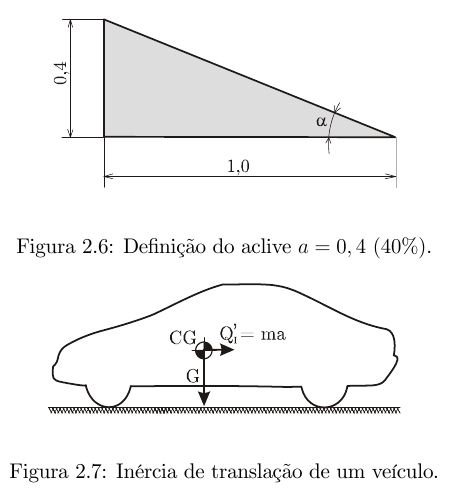

In [5]:
# Resistência de aclive
def resistencia_de_aclive(massa, aclive):
    Q_s = massa * 9.81 * np.sin(aclive) # Aclive em radiano
    return Q_s

#### Resistência de Inércia

Segundo Newton, um corpo para ter o seu estado de movimento (em repouso ou em
movimento retilíneo uniforme) alterado é necessário aplicar uma força. Para um automóvel,
que é um conjunto de inércias em translação e rotação, no cálculo da força a ser aplicada
para variar a velocidade deve ser levado em conta, além das massas em translação, as in-
ércias rotativas. Isto porque as inércias rotativas são submetidas a acelerações angulares
proporcionais a linear e, em função das relações de transmissão da caixa e do diferencial,
podem ser responsáveis por uma grande parcela de consumo de força (consequentemente
potência) durante a aceleração de um automóvel . Assim a abordagem será subdividida em
duas parcelas, uma devido as massas em translação e outra devida as massas em rotação. No
final, o efeito das duas parcelas será somado e corresponderá a resistência total de aceleração.

Fazendo a superposição dos efeitos temos:

$Q_I = m a (1 + \delta)$

Onde,

$\delta = {J\over m r_d^2}$

e

$J = J_r + i_d^2(J_t + i_{cj}^2 J_m)$

Uma boa aproximação de $\delta$ é dada por:

$\delta = 0,004 + 0,05 i_{cj}^2$

Sendo,

- $J$ ->  Inércia rotativa total
- $r_d$ ->  Raio dinâmico do pneu
- $J_r$ ->  Inércias das rodas e agregados tais como: rodas dianteiras, traseiras, parte do dife-
rencial do lado das rodas, dos discos e tambores de freio e dos cubos de roda.
- $i_d$ ->  Relação de transmissão do diferencial na $j'ésima$ marcha
- $i_{cj}$ -> Relação de transmissão da caixa de câmbio na $j'ésima$ marcha
- $J_t$ ->  Inércia da transmissão. Parte do diferencial do lado da caixa mais eixo cardam e
juntas, bem como a parte acionada da caixa.
- $J_m$ -> Inércia do motor. Motor e acessórios, volante, embreagem e parte acionante da
caixa de marchas.  


In [6]:
def resistencia_de_inercia(massa, aceleracao, i_cj):
    """
    massa : kg
    aceleracao : m/s2
    i_cj : adimensional

    Q_I -> N
    """
    Q_I = massa * aceleracao*(1 + (0.004 + 0.01*(i_cj**2)))
    return Q_I

#### Resistência de rolamento


A resistência ao rolamento é devida as perdas no par paneu pista. A mesma pode ser
calculada aproximadamente pela expressão empírica que segue

$Q_r = fG\cos\alpha$

Onde,

- $f$ -> Coeficiente de atrito de rolamento
- $G$ -> Peso do veículo
- $\alpha$ -> Inclinação da pista

Para pneus normais $f$ pode ser aproximado por:

$f = a + b({v\over100})^2$

$a = 0,0150$

$b = 0,052$

$v$ -> Velocidade do veículo dado em $[m/s]$

In [7]:
def resistencia_de_rolamento(velocidade, massa, aclive=0):
    """
    velocidade : m/s
    massa : kg
    aclive : rad

    Q_r -> N
    """
    f = 0.015 + 0.052*(velocidade/100)**2
    Q_r = f*massa*9.81*np.cos(aclive)
    return Q_r

#### Resistência Aerodinâmica

$Q_a = qC_xA$

- $q$ -> Pressão dinâmica
- $C_x$ -> Coeficiente de resistência aerodinâmica
- $A$ -> Área projetada da seção transversal do veículo

Sendo $q$ dado por

$q = {1\over2}\rho v^2$

e

$\rho = 1,22557 [kg/m^3]$  $@15^oC, 760 mm Hg$

In [8]:
def resistencia_aerodinamica(velocidade, C_x, A):
    """
    velocidade : m/s
    C_x : 
    A : m2
    """
    q = (1.22557*velocidade**2)/2
    Q_a = q*C_x*A
    return Q_a

### 2. Calcular o torque máximo que o layout permite que o carro pode transmitir ao solo (caítulo 3)

Para cálculo do torque máximo, será efetuado o cálculo da força matriz máxima de acordo com o layout de tração do carro e da multiplicação pelo raio dinâmico da roda.

**Veículo com tração integral**

$F_{m}^{máx} = \mu G cos\alpha $


- $\mu$ -> coeficiente de atrito entre o pneu e a pista, com valor de 0,72, correspondente à pista de asfalto;
- $G$ -> Peso do carro, calculado através da multiplicação da massa, igual a 1675 kg, e da gravidade, igual a $9,81 m/s^2$
- $\alpha$ -> ângulo de aclive. Nesse caso, será considerado o deslocamento no plano, visto que irá fornecer a máxima força motriz possível.
- $r_d$ -> raio dinâmico, cujo valor é tabelado de acordo com o tipo de carro. Nesse caso, igual a 0,2435352 m.

### 3. Para o veículo selecionado (capítulos 5 e 6)

#### Traçar o diagrama de potência líquida no cubo

In [9]:
def velocidade(rotacao_motor, relacao_transmissao, raio_dinamico, escorregamento=0.02):
    """
    rotacao_motor : rpm
    relacao_transmissao : adimensional
    raio_dinamico : m
    escorregamento : adimensional

    velocidade -> m/s
    """
    
    # eq. 5.12
    velocidade = 0.1047 * (1-escorregamento) * raio_dinamico * rotacao_motor/(relacao_transmissao)
    return velocidade


In [10]:
rel_list, vel_list, pot_list, mar_list = [], [], [], []
for rel, mar in zip(relacao_transmissao, marchas):
    for rot, pot in zip(rotacao, potencia):
        vel = velocidade(rot, rel, raio_dinamico)
        Pc_max = pot * rendimento_transmissao

        rel_list.append(rel)
        mar_list.append(mar)
        vel_list.append(vel)
        pot_list.append(pot)
        
data = pd.DataFrame(
    {'marcha': mar_list,
     'relacao_transmissao': rel_list,
     'velocidade [m/s]': vel_list,
     'potencia [kW]': pot_list})

data['velocidade [km/h]'] = data['velocidade [m/s]'] * 3.6

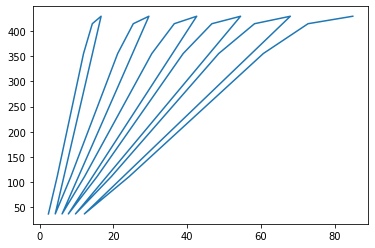

In [11]:
plt.plot(data['velocidade [m/s]'], data['potencia [kW]'])

In [12]:
res_aero_list = []
res_rol_list = []
for vel in vel_list:
    P_aero = vel*resistencia_aerodinamica(vel, C_x, A)/1000 # kW
    P_rol = vel*resistencia_de_rolamento(vel, massa)/1000 # kW

    res_aero_list.append(P_aero)
    res_rol_list.append(P_rol)

data['resistencia_aerodinamica [kW]'] = res_aero_list
data['resistencia_de_rolamento [kW]'] = res_rol_list


In [13]:
data['potencia_liquida [kW]'] = data['potencia [kW]'] \
                              - data['resistencia_aerodinamica [kW]'] \
                              - data['resistencia_de_rolamento [kW]']   

In [14]:
data[data['marcha']==1]['velocidade [m/s]']

0     2.381495
1     4.762990
2     7.144485
3     9.525980
4    11.907475
5    14.288971
6    16.670466
Name: velocidade [m/s], dtype: float64

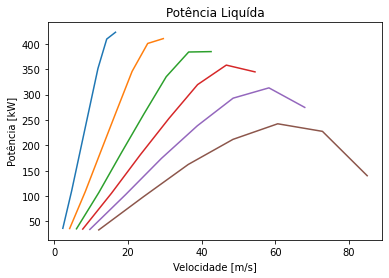

In [15]:
fig_pot_liq, pot_liq, = plt.subplots()
pot_liq.set_title('Potência Liquída')
pot_liq.set_xlabel('Velocidade [m/s]')
pot_liq.set_ylabel('Potência [kW]')
for i in marchas:
    pot_liq.plot(data[data['marcha']==i]['velocidade [m/s]'], data[data['marcha']==i]['potencia_liquida [kW]'])
fig_pot_liq.show()

#### Determinar acelerações máximas em cada marcha

$\delta = {J\over m r_d^2}$

Uma boa aproximação de $\delta$ é dada por:

$\delta = 0,004 + 0,05 i_{cj}^2$

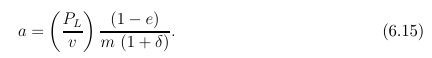

In [16]:
data['delta'] = 0.004 + 0.01*(data['relacao_transmissao']**2)
e = 0.02
data['aceleracao [m/s2]'] = (1000*data['potencia_liquida [kW]']/data['velocidade [m/s]']) * (1-e) / (massa * (1 + data['delta']))

In [17]:
aceleracao_maxima = data.pivot_table(index='marcha', values='aceleracao [m/s2]', aggfunc=np.max)
aceleracao_maxima

,aceleracao [m/s2]
marcha,
1,8.205530
2,7.067895
3,5.499070
4,4.340855
5,3.356078
6,2.493145


#### Determinar aclives máximos em cada marcha

eq. 6.11

$sin\alpha = {P_l\over v}{(1-e)\over G}$ 

In [18]:
data['seno_alpha'] = 1000*data['potencia_liquida [kW]'] * (1 - e) / (data['velocidade [m/s]'] * massa * 9.81)

**Precisa considerar o torque maximo do leiaute**

In [19]:
data[['marcha', 'seno_alpha']]
aclive_maximo = data.pivot_table(index='marcha', values='seno_alpha', aggfunc=np.max)
aclive_maximo

,seno_alpha
marcha,
1,1.760680
2,0.974339
3,0.657297
4,0.489827
5,0.366110
6,0.265937


#### Determinar velocidade máxima e mínima em cada marcha

In [20]:
vel_max_min = data.pivot_table(values='velocidade [m/s]', index='marcha', aggfunc=[np.max, np.min])
vel_max_min.columns = ['velocidade maxima [m/s]', 'velocidade minima [m/s]']
vel_max_min

,velocidade maxima [m/s],velocidade minima [m/s]
marcha,,
1,16.670466,2.381495
2,29.636383,4.233769
3,42.602301,6.086043
4,54.509777,7.787111
5,68.004916,9.714988
6,84.939992,12.134285


#### Determinar o tempo para acelerar da imobilidade até:

80km/h;

100km/h;

velocidade máxima do veículo.

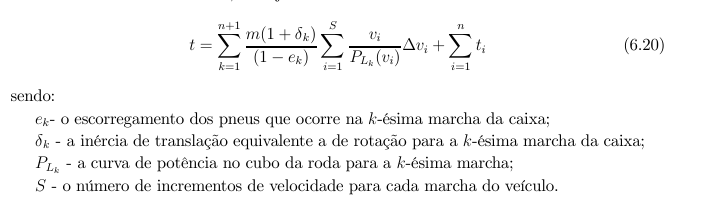

Primeiro será computado todos os $\Delta v_i$

In [21]:
velocidade_filtro = data['velocidade [m/s]'].cummax().drop_duplicates()
data['delta_v [m/s]'] = velocidade_filtro.diff().fillna(0)

data_aux = data[data['velocidade [m/s]'].isin(velocidade_filtro)][:-1].copy()

Vamos dividir essa equacao em tres parcelas principais. Cada uma delas corresponde a um somatorio presente na equacao.

In [22]:
parcela_1 = massa*(1+data_aux['delta']) / (1-e)
parcela_2 = data_aux['velocidade [m/s]'] * data_aux['delta_v [m/s]'] / (1000*data_aux['potencia_liquida [kW]'])

data_aux['tempo'] = parcela_1 * parcela_2

def tempo_de_aceleracao(vi, vf):
    """
    retorna o tempo para variar a velocidade de `vi` ate `vf`
    vi : km/h
    vf : km/h

    retorna -> [s]
    """
    vel_min_mask = (data_aux['velocidade [km/h]']>=vi)
    vel_max_mask = (data_aux['velocidade [km/h]']<=vf)
    tempo = data_aux['tempo'][vel_min_mask & vel_max_mask].cumsum().max() 
    print(f'O tempo para acelerar de {vi} km/h a {vf} km/h é:\t{tempo} s')


In [23]:
tempo_de_aceleracao(0, 80)
tempo_de_aceleracao(0, 100)
tempo_de_aceleracao(0, 315)
tempo_de_aceleracao(60, 120)

O tempo para acelerar de 0 km/h a 80 km/h é:	2.558684684288167 s
O tempo para acelerar de 0 km/h a 100 km/h é:	3.178660968707118 s
O tempo para acelerar de 0 km/h a 315 km/h é:	18.314328891838993 s
O tempo para acelerar de 60 km/h a 120 km/h é:	2.4461822353169187 s


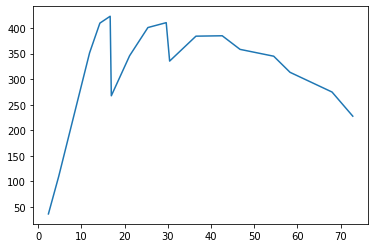

In [24]:
plt.plot(data_aux['velocidade [m/s]'].cummax(), data_aux['potencia_liquida [kW]'])

## 4. Calcular a massa dos freios dianteiros e traseiros para freadas de emergência, bem como o tempo e a distância percorrida para imobilizar o veículo a partir das seguintes velocidades 

Para o cálculo das massas dos freios dianteiros e traseiros, foram utilizadas as seguintes fórmulas para os freios dianteiros e traseiros, respectivamente.

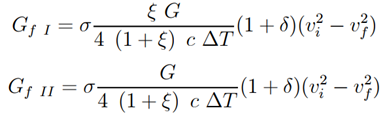

A seguir, são apresentados os parâmetros e as hipóteses assumidas.

- Calor absorvido pelo freio -> nesse caso, como todos os freios são de disco, o valor assumido será de 99%;
- G -> ao invés de utilizar-se o peso do automóvel, foi considerado o valor de sua massa, visto que essa era a definição pedida pelo enunciado da questão. Dessa forma, G = 1675 Kg;
- Calor específico do material do freio -> o Nissan GT-R Nismo utiliza freios de alta performance da marca Brembo, cujo material é ferro fundido. Dessa forma, o valor considerado para esse parâmetro foi de 544,27 J/KgºC;
- Relação de inércia translação/rotação -> considerando que a aplicação do freio ocorre com a embreagem desacoplada, o valor da relação é igual à 0,05;
- Velocidade inicial -> foram consideradas as 3 velocidades propostas, em m/s;
- Velocidade final -> velocidade nula, automóvel parado;
- Delta de temperatura -> para o cálculo do delta de temperatura, considerou-se a diferença entre a temperatura máxima suportada pela guarnição, igual a 700ºC, e a temperatura ambiente, igual a 20°C;

Para o cálculo do índice de frenagem, utilizou-se a seguinte fórmula:


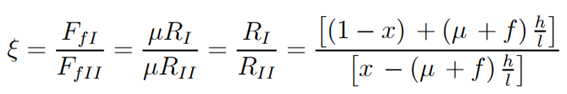

Para o cálculo do índice de frenagem, foram considerados os seguintes parâmetros:
- Distribuição de carga (x) -> valor tabelado para o tipo de carro. Nesse caso, x = 0,55;
- Coeficiente de atrito -> foi considerado o coeficiente de atrito entre pneu e asfalto, com valor igual a 0,72;
- Distância entre eixos -> valor tabelado para o tipo de carro. Nesse caso, l = 2,78 metros;
- Altura do centro de gravidade -> valor tabelado par o tipo de carro. Nesse caso, h = 0,5 metros;
- Coeficiente de atrito de rolamento -> foi considerado o valor correspondente à asfalto rugoso, igual a 0,011.

Para o cálculo das distâncias de frenagem, foi considerada a seguinte equação:


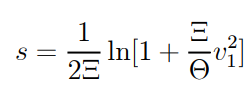

E para o cálculo do tempo até parada total do veículo, a equação considerada foi:

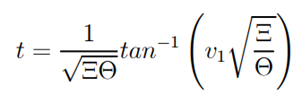

Para o cálculo das constantes apresentadas nas equações acima, foram consideradas as seguintes formulações:

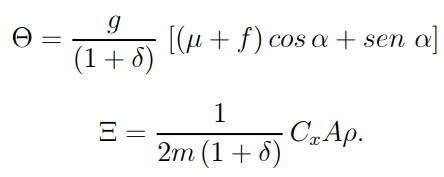

A seguir, são apresentados os parâmetros e as hipóteses assumidas.

- Gravidade (g) -> 9,81 m/s2;
- Relação entre inércia de translação/rotação -> 0,05;
- Coeficiente de atrito pneu-pista -> para pista feita de asfalto, foi considerado o valor de 0,72;
- Aclive -> foi considerado o deslocamento do automóvel no plano;
- Coeficiente de atrito de rolamento -> foi considerado o valor correspondente à asfalto rugoso, igual a 0,011.
- Massa -> valor tabelado para o tipo de carro, igual a 1675 Kg;
- Coeficiente de penetração -> valor tabelado para o tipo de carro, igual a 0,26;
- Área projetada -> valor tabelado para o tipo de carro, igual a 2,21;
- Densidade do vento -> 1,22557 g/cm3.

As respostas para as massas do freios à disco dianteiros e traseiros, tempo de frenagem e distância de frenagem se encontram na seção de respostas desse relatório.


# Respostas

## Questão 1 

### Resistência Mecânica
Considerando um rendimento de transmissão é $90\%$ e potência do motor é $440 kW$, temos que a resistência mecânica, dada em $kW$, para essa condição é:

In [25]:
resistencia_mecanica(rendimento_transmissao=rendimento_transmissao, potencia_motor=440)

43.99999999999999

### Resistência de Aclive
Considerando a massa do carro igual $1675 kg$ e que o veículo está subindo um aclive com inclinação de $30º$, a resistência de aclive, dada em $N$, é:

In [26]:
aclive = np.pi/6
resistencia_de_aclive(massa=massa, aclive=aclive)

8215.874999999998

### Resistência de Inércia
Considerando a massa do carro igual a $1675kg$ e que está acelerando $6,5 m/s^2$ na primeira marcha com relação de transmissão de $10,49$, a resistência de inércia dada em $N$ é dada por:

In [27]:
resistencia_de_inercia(massa=massa, aceleracao=6.5, i_cj=relacao_transmissao[0])

22917.698866576375

### Resistência de Rolamento
Considerando a massa do carro igual a $1675kg$ e uma velocidade de $30m/s$, a resistência de rolamento, dada em $N$, é:

In [28]:
resistencia_de_rolamento(velocidade=30, massa=massa)

323.37684

### Restência Aerodinâmica
Considerando que o veículo está a $30m/s$, tem um coeficiente de resistência aerodinâmica de $0,26$ e área projetada igual a $2,21 m^2$, a resistência aerodinâmica é dada em $N$ por:

In [29]:
resistencia_aerodinamica(velocidade=30, C_x=C_x, A=A)

316.8956349

## Questão 2

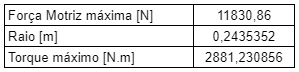

## Questão 3

### Diagrama de potência líquida

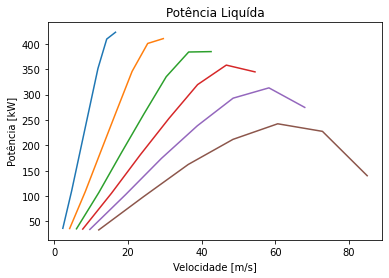

In [30]:
fig_pot_liq

### Aceleração máxima em cada marcha

In [31]:
aceleracao_maxima

,aceleracao [m/s2]
marcha,
1,8.205530
2,7.067895
3,5.499070
4,4.340855
5,3.356078
6,2.493145


Verificando se o torque máximo permitido pelo layout não causa uma aceleração maior que as calculadas:

In [32]:
torque_maximo = 3005
forca = torque_maximo/raio_dinamico
a_max_layout = forca/massa
a_max_layout

7.3666141516555665

Como se pode verificar, esse valor é maior que o valor encontrado na primeira marcha, por isso será necessário substituir qualquer valore que seja maior que `a_max_layout`:

In [33]:
aceleracao_maxima[aceleracao_maxima['aceleracao [m/s2]']>a_max_layout] = a_max_layout
aceleracao_maxima

,aceleracao [m/s2]
marcha,
1,7.366614
2,7.067895
3,5.499070
4,4.340855
5,3.356078
6,2.493145


### Aclive máximo em cada marcha

In [34]:
aclive_maximo

,seno_alpha
marcha,
1,1.760680
2,0.974339
3,0.657297
4,0.489827
5,0.366110
6,0.265937


O veículo estudado em questão possui tração integral. Assim, o máximo aclive suportado é dado por:

image.png

In [35]:
f = 0.015 + 0.052*(1/100)**2
mi = 0.72

alpha_max = np.arctan(0.72 - f)
seno_alpha_max = np.sin(alpha_max)
seno_alpha_max

0.5761989342727334

Assim como foi feito para a aceleração máxima, o aclive máximo definido pelo layout também limita o comportamento do veículo. Realizando a alteração, fica-se com:

In [36]:
aclive_maximo[aclive_maximo['seno_alpha']>seno_alpha_max] = seno_alpha_max
aclive_maximo

,seno_alpha
marcha,
1,0.576199
2,0.576199
3,0.576199
4,0.489827
5,0.366110
6,0.265937


### Velocidade máxima e mínima em cada marcha

In [37]:
vel_max_min

,velocidade maxima [m/s],velocidade minima [m/s]
marcha,,
1,16.670466,2.381495
2,29.636383,4.233769
3,42.602301,6.086043
4,54.509777,7.787111
5,68.004916,9.714988
6,84.939992,12.134285


### Acelerações

In [38]:
tempo_de_aceleracao(0, 80)
tempo_de_aceleracao(0, 100)
tempo_de_aceleracao(0, 280)
tempo_de_aceleracao(60, 120)

O tempo para acelerar de 0 km/h a 80 km/h é:	2.558684684288167 s
O tempo para acelerar de 0 km/h a 100 km/h é:	3.178660968707118 s
O tempo para acelerar de 0 km/h a 280 km/h é:	18.314328891838993 s
O tempo para acelerar de 60 km/h a 120 km/h é:	2.4461822353169187 s


## Questão 4

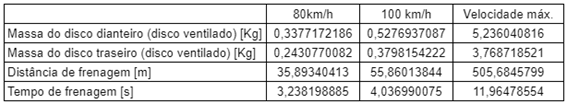

## Questão 5

Como pode ser observado na imagem a seguir, retirada do site https://zeperfs.com/fiche4841-nissan-gt-r-nismo.htm#Performances, os valores calculados para aceleração ficaram relativamente próximos dos dados medidos.

Com isso percebe-se que a modelagem apresentada pela apostila do professor é adequada para uma avaliação de desempelho veicular.

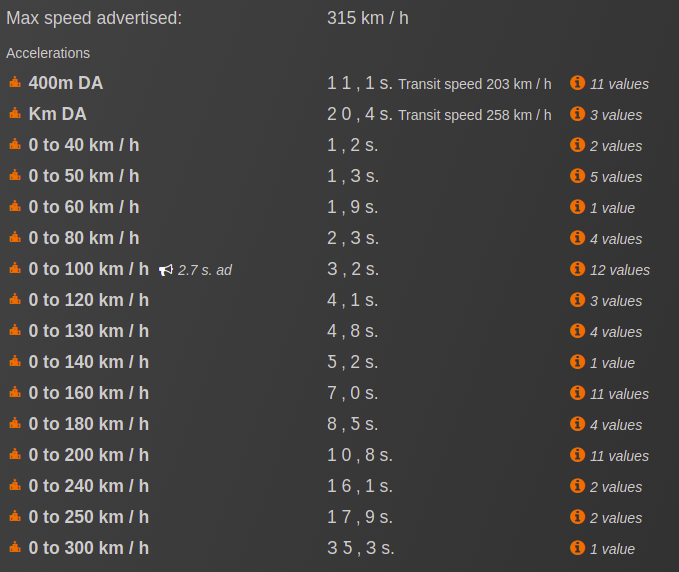

Para a parte de frenagem, observa-se que os valores diferem em quase 100% dos valores estipulados para esse modelo de carro. Por causa dessa diferença, a dupla buscou por possíveis erros nas formulações ou nos parâmetros de entrada, mas não encontrou algo que pudesse ser alterado para ajustar os valores.

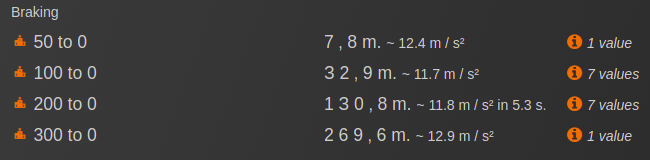